In [763]:
import Model
import image
import loss
import importlib
importlib.reload(Model)
importlib.reload(image)
importlib.reload(loss)
from image import load_image, imshow, clip_pixel, tensor_to_image
from Model import Style_Extractor, Content_Extractor, StyleContentModel, features_maps_extractor, gram_matrix
from loss import compute_total_loss, compute_style_loss, compute_content_loss
import os
import tensorflow as tf
from tqdm import tqdm
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [764]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

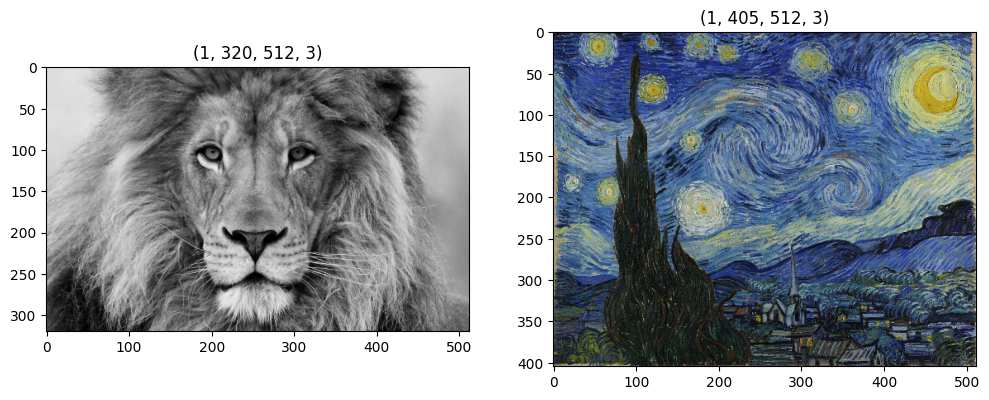

In [765]:
content_image = load_image('lion.jpg')
style_image = load_image('vangogh.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, f'{content_image.shape}')

plt.subplot(1, 2, 2)
imshow(style_image, f'{style_image.shape}')

In [766]:
# import tensorflow_hub as hub
# hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
# tensor_to_image(stylized_image)

In [767]:
# x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# prediction_probabilities = vgg(x)
# prediction_probabilities.shape

In [768]:
# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [769]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_152
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [770]:
Adam = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [771]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def vgg(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)

    return model

In [772]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"

    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [773]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [774]:

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  21642.566
    mean:  324.27472

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  85807.04
    mean:  11785.395

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  239565.38
    mean:  9530.803

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4066953.5
    mean:  183087.73

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  154469.17
    mean:  1248.8035

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1373.4274
    mean:  13.745882


In [775]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [776]:
image = tf.Variable(content_image)
image.shape

TensorShape([1, 320, 512, 3])

In [777]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [778]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

total_variation_weight = 30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  Adam.apply_gradients([(grad, image)])
  image.assign(clip_pixel(image))

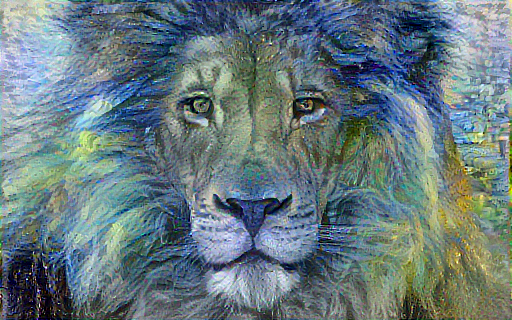

 30%|███       | 3/10 [07:35<17:49, 152.84s/it]

Train step: 300
..........................................................................

 30%|███       | 3/10 [09:29<22:09, 189.89s/it]


KeyboardInterrupt: 

In [780]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in tqdm(range(epochs)):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))